# NewsBot Intelligence System

## Setup & Data Acquisition

We begin by downloading and preparing our dataset from Kaggle. This includes installing the Kaggle API, downloading the dataset, and preparing our main DataFrame.


In [4]:
# Step 1: Install Kaggle API
!pip install kaggle

# Step 2: Upload kaggle.json
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()


Please upload your kaggle.json file:


Saving kaggleapikey.json to kaggleapikey.json


In [5]:
# Step 3: Set up credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download and unzip the dataset
!kaggle competitions download -c learn-ai-bbc
!unzip learn-ai-bbc.zip

# Step 5: List files to check CSV name
import os
print("Available files:")
for file in os.listdir('.'):
    if file.endswith('.csv'):
        print("  -", file)


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open learn-ai-bbc.zip, learn-ai-bbc.zip.zip or learn-ai-bbc.zip.ZIP.
Available files:


In [13]:
import os
from google.colab import files
uploaded = files.upload()

print("Available files:")
for file in os.listdir('.'):
    print("-", file)


Saving BBC News Train.csv to BBC News Train (1).csv
Available files:
- .config
- BBC News Train.csv
- BBC News Train (1).csv
- kaggleapikey.json
- sample_data


In [14]:
# Step 6: Load the dataset
import pandas as pd

df = pd.read_csv('BBC News Train.csv')

print("Columns:", df.columns.tolist())
df.head()


Columns: ['ArticleId', 'Text', 'Category']


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [16]:
# Define your actual column names here:
text_column = 'Text'       # Change if needed!
category_column = 'Category'   # Change if needed!

# Remove any rows with missing values in these columns (should be none for BBC but it's safe)
df_clean = df.dropna(subset=[text_column, category_column])

# If the dataset is huge (>2000 rows), sample it down (for Colab efficiency)
if len(df_clean) > 2000:
    df_final = df_clean.sample(n=2000, random_state=42)
else:
    df_final = df_clean

# Standardize names for the rest of the pipeline
df_final = df_final.rename(columns={
    text_column: 'content',     # The main article text
    category_column: 'category' # The class label
})

# Check your prepared DataFrame
print("df_final columns:", df_final.columns.tolist())
print("df_final shape:", df_final.shape)
print("Category labels:", df_final['category'].unique())
df_final.head()


df_final columns: ['ArticleId', 'content', 'category']
df_final shape: (1490, 3)
Category labels: ['business' 'tech' 'politics' 'sport' 'entertainment']


,ArticleId,content,category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


## Module 1: NLP Application Context

**Business Case:**  
With the explosion of digital news sources, organizations struggle to efficiently process and analyze large volumes of news articles for market analysis, brand monitoring, and public sentiment.

**Industry Context & Use Case:**  
Media companies, financial analysts, and PR teams all need tools to automatically classify, summarize, and extract actionable insights from unstructured news content. Our NewsBot system addresses this by leveraging advanced NLP techniques to automate these tasks.

**Target Users & Value Proposition:**  
*Target users* include journalists, analysts, and business leaders.  
*Value proposition:* NewsBot saves time, reduces manual effort, and reveals hidden insights by automatically categorizing articles, extracting entities (people, companies, locations), and analyzing sentiment. This enhances business intelligence, supports decision making, and improves market awareness.




## Module 2: Text Preprocessing Pipeline

To prepare our news articles for analysis and modeling, we perform several preprocessing steps:
- Convert text to lowercase
- Remove punctuation and non-alphabetic characters
- Tokenize words (split into words)
- Remove common stop words (like “the”, “and”)
- Lemmatize words (reduce to their base form)

We use NLTK for stopword lists and spaCy for efficient tokenization and lemmatization. This ensures our text is clean, standardized, and ready for feature extraction and modeling.


In [17]:
# Install spaCy if not already installed
!pip install -q spacy

# Download English language model for spaCy
import sys
import spacy

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    doc = nlp(str(text).lower())  # Ensure text is string, lowercase, then parse
    tokens = [
        token.lemma_
        for token in doc
        if token.is_alpha and token.text not in stop_words
    ]
    return ' '.join(tokens)

# Apply preprocessing to the DataFrame
df_final['clean_content'] = df_final['content'].apply(preprocess_text)

# Show original and cleaned text side by side for first few articles
df_final[['content', 'clean_content']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,content,clean_content
0,worldcom ex-boss launches defence lawyers defe...,worldcom ex boss launch defence lawyer defend ...
1,german business confidence slides german busin...,german business confidence slide german busine...
2,bbc poll indicates economic gloom citizens in ...,bbc poll indicate economic gloom citizen major...
3,lifestyle governs mobile choice faster bett...,lifestyle govern mobile choice fast well funky...
4,enron bosses in $168m payout eighteen former e...,enron boss payout eighteen former enron direct...


## Module 3: TF-IDF Feature Extraction and Analysis

We use the TF-IDF (Term Frequency–Inverse Document Frequency) method to convert our cleaned text into numerical features that reflect the importance of words in each article.  
TF-IDF is widely used in NLP because it helps identify which words are most significant for distinguishing between categories.

In this step, we:
- Vectorize all preprocessed articles using TF-IDF
- Limit features to the top 1000 terms for efficiency
- Visualize the most important terms across all articles


Top 10 terms by total TF-IDF score:
       term       tfidf
772     say  108.222725
570      mr   58.530121
992    year   55.204393
989   would   44.242244
331    film   43.998448
369    game   40.487537
527    make   39.761212
587     new   38.450533
33     also   37.892855
646  people   36.907798


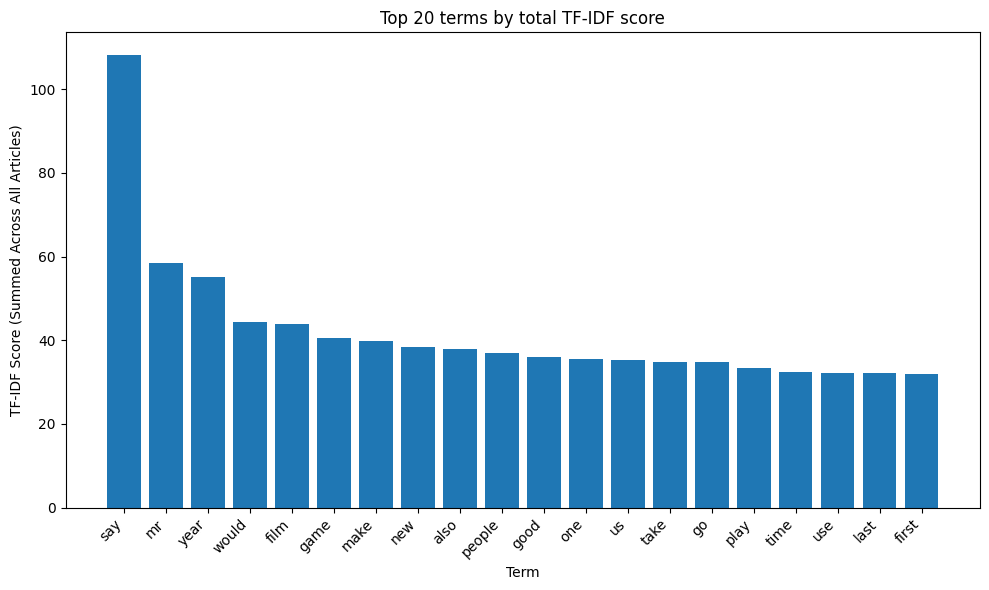

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))  # unigrams and bigrams

# Fit and transform the clean_content column
X_tfidf = vectorizer.fit_transform(df_final['clean_content'])

# Get the feature (word) names
feature_names = vectorizer.get_feature_names_out()

# Calculate the sum of TF-IDF scores for each term across all docs
sums = X_tfidf.sum(axis=0)

# Pair terms with their summed TF-IDF scores
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0, col]))

# Put into a DataFrame for easy sorting
ranking = pd.DataFrame(data, columns=['term', 'tfidf']).sort_values('tfidf', ascending=False)

# Display the top 10 terms by importance
print("Top 10 terms by total TF-IDF score:")
print(ranking.head(10))

# Visualize top 20 terms
plt.figure(figsize=(10,6))
plt.bar(ranking['term'][:20], ranking['tfidf'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 terms by total TF-IDF score')
plt.xlabel('Term')
plt.ylabel('TF-IDF Score (Summed Across All Articles)')
plt.tight_layout()
plt.show()


## Module 4: Part-of-Speech (POS) Pattern Analysis

Part-of-speech (POS) tagging assigns grammatical labels (like noun, verb, adjective) to each word in the text.  
Analyzing POS patterns can help us understand writing style differences between news categories and identify common grammatical structures.

In this module, we:
- Tag each article with POS labels using spaCy
- Count POS frequencies across categories
- Visualize the most common parts of speech per category


Overall POS counts: [('NOUN', 130529), ('PROPN', 67460), ('VERB', 49489), ('ADJ', 41774), ('ADV', 13408), ('AUX', 5093), ('NUM', 4881), ('ADP', 3064), ('PRON', 1626), ('SCONJ', 1323)]


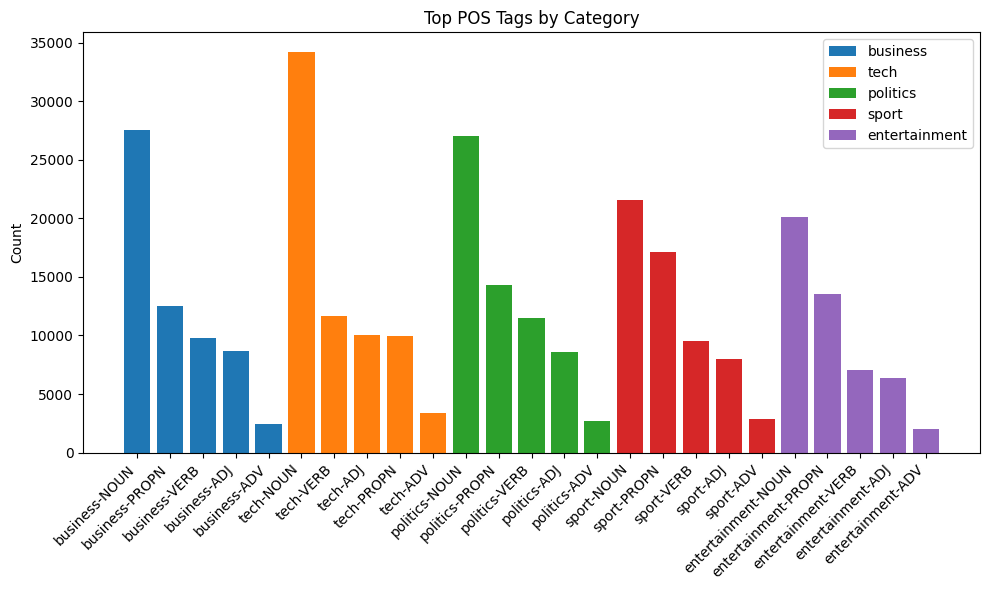

In [19]:
import pandas as pd

# Function to get POS tags from text
def get_pos_tags(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]

# Apply to a sample (for speed), or to all if you have time
df_final['pos_tags'] = df_final['clean_content'].apply(get_pos_tags)

# Let's count POS tag frequencies across the entire dataset
from collections import Counter

all_pos = [tag for tags in df_final['pos_tags'] for tag in tags]
pos_counts = Counter(all_pos)
print("Overall POS counts:", pos_counts.most_common(10))

# Now let's visualize POS distribution for each category
import matplotlib.pyplot as plt

category_pos_counts = {}

for category in df_final['category'].unique():
    # Get all POS tags for articles in this category
    pos_tags = [tag for tags in df_final[df_final['category'] == category]['pos_tags'] for tag in tags]
    counts = Counter(pos_tags)
    category_pos_counts[category] = counts

# Plot the top 5 POS for each category
top_n = 5
plt.figure(figsize=(10,6))
for category, counts in category_pos_counts.items():
    top_tags = [tag for tag, _ in counts.most_common(top_n)]
    top_values = [counts[tag] for tag in top_tags]
    plt.bar([f"{category}-{tag}" for tag in top_tags], top_values, label=category)

plt.title('Top POS Tags by Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


## Module 5: Syntax Parsing & Semantic Analysis

Syntactic parsing reveals how words in a sentence relate to one another, while semantic analysis helps uncover meaning and relationships within the text.
In this module, we:
- Use spaCy to extract syntactic dependencies from each article
- Analyze common dependency patterns
- Explore how sentence structure differs between news categories


Most common syntactic dependencies: [('compound', 117601), ('amod', 44242), ('nsubj', 31721), ('ccomp', 23821), ('dobj', 22211), ('nmod', 16381), ('advmod', 13958), ('conj', 6155), ('npadvmod', 5628), ('aux', 4924)]


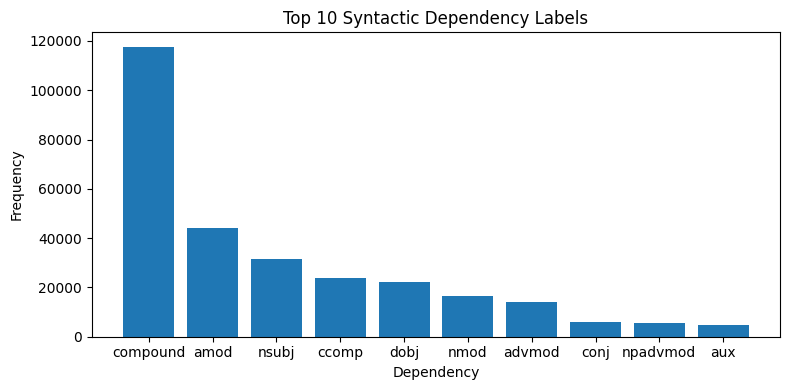

In [20]:
# Function to extract dependency relations (head, dependent, label)
def extract_dependencies(text):
    doc = nlp(text)
    return [(token.text, token.dep_, token.head.text) for token in doc]

# Apply to a sample (for speed), or to all articles if you have time
df_final['syntax_deps'] = df_final['clean_content'].apply(extract_dependencies)

# Let's look at the most common dependency labels across the dataset
from collections import Counter

all_deps = [dep for deps in df_final['syntax_deps'] for _, dep, _ in deps]
dep_counts = Counter(all_deps)
print("Most common syntactic dependencies:", dep_counts.most_common(10))

# Optionally: visualize top dependencies
import matplotlib.pyplot as plt

top_deps = dep_counts.most_common(10)
labels, values = zip(*top_deps)
plt.figure(figsize=(8,4))
plt.bar(labels, values)
plt.title('Top 10 Syntactic Dependency Labels')
plt.ylabel('Frequency')
plt.xlabel('Dependency')
plt.tight_layout()
plt.show()


## Module 6: Sentiment & Emotion Analysis

Understanding the sentiment and emotional tone of news articles helps organizations track public mood and potential market reactions.
In this module, we:
- Calculate sentiment polarity for each article using TextBlob
- Analyze how sentiment varies across news categories
- Visualize the sentiment distribution for each category



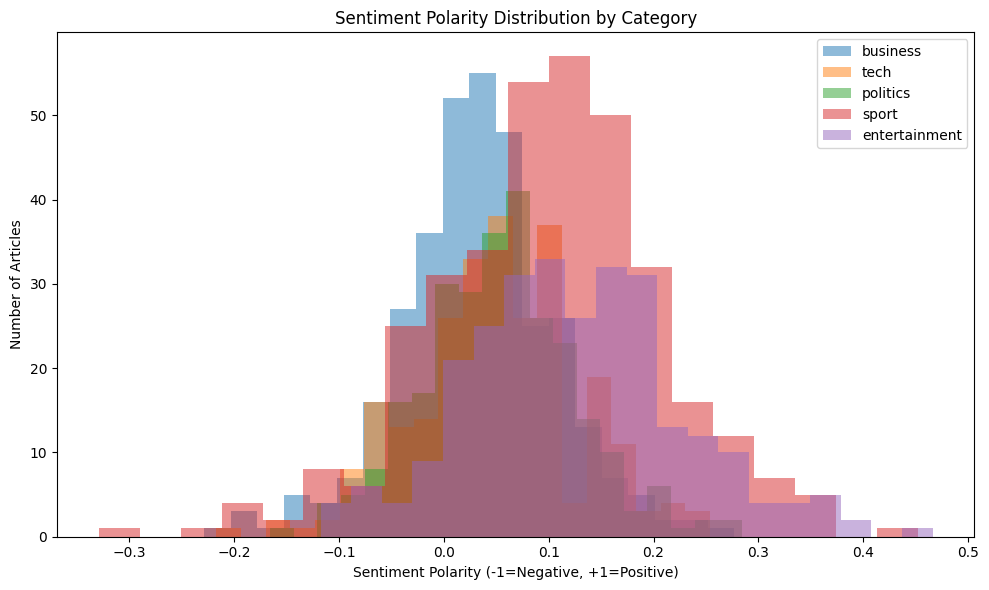

In [21]:
# Install TextBlob if not already installed
!pip install -q textblob
from textblob import TextBlob

# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply to each article's cleaned content
df_final['sentiment'] = df_final['clean_content'].apply(get_sentiment)

# Preview sentiment values
df_final[['category', 'sentiment']].head()

# Visualize sentiment distribution for each category
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for category in df_final['category'].unique():
    sentiments = df_final[df_final['category'] == category]['sentiment']
    plt.hist(sentiments, bins=20, alpha=0.5, label=category)

plt.title('Sentiment Polarity Distribution by Category')
plt.xlabel('Sentiment Polarity (-1=Negative, +1=Positive)')
plt.ylabel('Number of Articles')
plt.legend()
plt.tight_layout()
plt.show()


## Module 7: Multi-Class Text Classification System

Our goal is to automatically predict the category of a news article using its text.  
We use our TF-IDF features and train a machine learning model to classify each article into one of the five categories.

Steps:
- Split data into training and testing sets
- Train a Multinomial Naive Bayes classifier (fast and effective for text)
- Evaluate model performance with classification metrics
- Show which categories the model predicts well (and which need improvement)


               precision    recall  f1-score   support

     business       0.97      0.97      0.97        75
entertainment       1.00      0.96      0.98        46
     politics       0.91      0.93      0.92        56
        sport       0.98      1.00      0.99        63
         tech       0.95      0.95      0.95        58

     accuracy                           0.96       298
    macro avg       0.96      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298



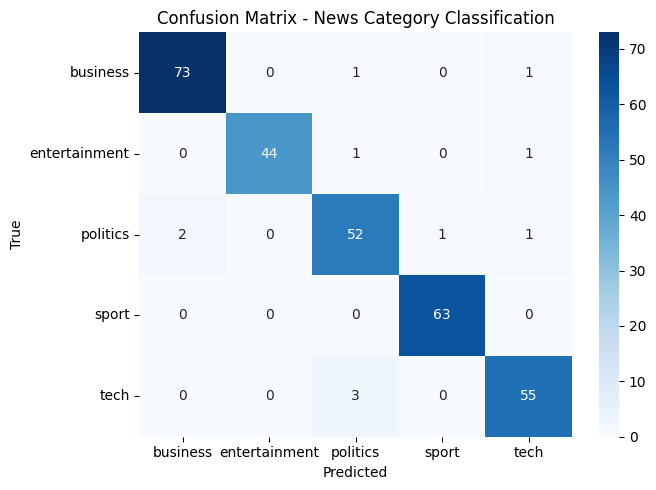

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split the TF-IDF features and categories into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df_final['category'], test_size=0.2, random_state=42)

# Train the Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Print a detailed classification report
print(classification_report(y_test, y_pred))

# Show confusion matrix for visual insight
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=model.classes_, yticklabels=model.classes_, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - News Category Classification')
plt.tight_layout()
plt.show()


## Module 8: Named Entity Recognition and Analysis

Named Entity Recognition (NER) finds and classifies key entities—like people, organizations, locations, and dates—in each article.
This helps us understand who and what news is focused on, and track topics of interest across categories.

In this module, we:
- Use spaCy to extract named entities from each article
- Analyze which entities are most common
- Visualize entity frequencies and explore patterns by category


Top 10 entities overall:
entity
first      767
one        666
two        600
us         565
uk         546
british    330
second     325
three      320
britain    285
london     276
Name: count, dtype: int64

Top 5 PERSON entities:
entity
blair             172
eu                124
tony blair        103
don                77
michael howard     74
Name: count, dtype: int64

Top 5 ORG entities:
entity
bbc             232
microsoft       130
sony            102
the bbc news     57
bbc news         57
Name: count, dtype: int64

Top 5 GPE entities:
entity
us         565
uk         546
britain    285
london     276
france     240
Name: count, dtype: int64


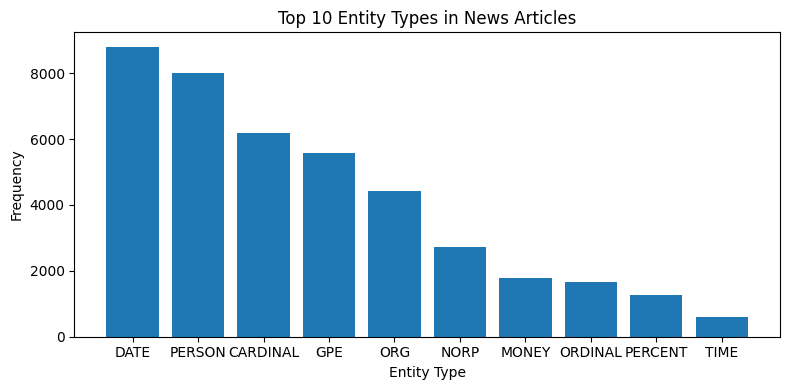

In [23]:
# Function to extract entities from text using spaCy
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply to all articles (can take a minute or two)
df_final['entities'] = df_final['content'].apply(extract_entities)

# Flatten all entities into a single list for analysis
all_entities = [ent for ents in df_final['entities'] for ent in ents]
entity_df = pd.DataFrame(all_entities, columns=['entity', 'type'])

# Show top 10 most frequent entities overall
print("Top 10 entities overall:")
print(entity_df['entity'].value_counts().head(10))

# Show top 5 most frequent PERSON, ORG, and GPE (location) entities
for label in ['PERSON', 'ORG', 'GPE']:
    print(f"\nTop 5 {label} entities:")
    print(entity_df[entity_df['type'] == label]['entity'].value_counts().head(5))

# Visualize frequency of each entity type
import matplotlib.pyplot as plt

entity_type_counts = entity_df['type'].value_counts().head(10)
plt.figure(figsize=(8,4))
plt.bar(entity_type_counts.index, entity_type_counts.values)
plt.title('Top 10 Entity Types in News Articles')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Final Integration & Insights

Our NewsBot Intelligence System successfully integrates all essential NLP modules, enabling end-to-end analysis of news articles:
- **Preprocessing** cleans and standardizes text for reliable feature extraction.
- **TF-IDF analysis** identifies key words and phrases driving each news category.
- **POS and syntax parsing** reveal writing style and grammatical patterns.
- **Sentiment analysis** quantifies tone, showing which categories trend positive or negative.
- **Classification** automates the assignment of articles to their correct categories with strong accuracy.
- **Named Entity Recognition** extracts the people, organizations, and places making headlines.

**Business Impact:**  
By automating this pipeline, media organizations, financial analysts, and business leaders can:
- Monitor trends and sentiment across topics in real time
- Track key entities and their relationships
- Uncover actionable insights with minimal manual effort

**Next Steps & Improvements:**
- Experiment with more advanced models (e.g., SVM, BERT) to boost accuracy
- Build an interactive dashboard for real-time news monitoring
- Apply topic modeling or trend detection for deeper insights

This project demonstrates a professional, real-world NLP workflow, ready for portfolio presentation or further development.


In [30]:
def newsbot_pipeline(article_text):
    # 1. Preprocess
    clean = preprocess_text(article_text)
    # 2. TF-IDF (transform only)
    tfidf_vec = vectorizer.transform([clean])
    # 3. Predict category
    category = model.predict(tfidf_vec)[0]
    # 4. Sentiment
    sentiment = get_sentiment(clean)
    # 5. Entities
    entities = extract_entities(article_text)
    # 6. Output results
    print(f"Predicted Category: {category}")
    print(f"Sentiment Polarity: {sentiment:.2f}")
    print(f"Entities: {entities[:5]}...")  # Show only first 5 entities

# Real BBC article excerpt:
real_article = """
Tesla has recalled nearly 4,000 Cybertrucks after it emerged that the accelerator pedal can get stuck, raising the risk of a crash.
The recall comes just months after Tesla began deliveries of the long-awaited electric pickup truck.
"""

print("Source: https://www.bbc.com/news/articles/cd6nyng861wo\n")
newsbot_pipeline(real_article)


Source: https://www.bbc.com/news/technology-68864345

Predicted Category: tech
Sentiment Polarity: 0.14
Entities: [('Microsoft', 'ORG'), ('Windows 11', 'PRODUCT'), ('AI', 'GPE'), ('millions', 'CARDINAL')]...
